<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3c_OSI_SAF_sea_ice_mapping_Ice_Type.ipynb" target="_blank"><< Mapping OSI SAF sea ice type</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3e_OSI_SAF_sea_ice_mapping_Ice_Emissivity.ipynb" target="_blank">Mapping OSI SAF sea ice emissivity >></a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sea-ice/HEAD?labpath=1_OSI_SAF_sea_ice_introductory%2F1_3d_OSI_SAF_sea_ice_mapping_ice_drift.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea ice parameters : Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb" target="_blank">1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb</a>**

</div>
<hr>

# 1.3d Mapping OSI SAF sea ice drift 
### Data used 

| Dataset | EUMETSAT collection ID | OSI SAF website description | OSI SAF identifier |
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| Global Low Resolution Sea Ice Drift | EO:EUM:DAT:MULT:GBL-LR-SIDR | <a href="https://osi-saf.eumetsat.int/products/osi-405-c" target="_blank">Description</a> | OSI-405-c | 


### Learning outcomes

At the end of this notebook you will know;
* How to open Sea Ice Drift netcdf
* Map Sea Ice Drift using cartopy 

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Mapping sea ice concentration - Northern Hemisphere](#section1)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [13]:
# library imports 
import os                               # a library that allows us access to basic operating system commands
import xarray as xr                     # a library that supports the use of multi-dimensional arrays in Python
import matplotlib as mpl                # a library for visualization
import matplotlib.patches as mpatches   # a part of the plotting library
import matplotlib.pyplot as plt         # a library that supports plotting
import matplotlib.cm as mpl_cm          # a part of the plotting library that provides colour maps
from matplotlib.colors import ListedColormap #allows to use colors
import cartopy.crs as ccrs              # a mapping library that supports reprojection
import cartopy.feature as cfeature      # a part of the mapping library that provides features such as coastlines
import cmocean                          # colormaps for ocean products
import cmcrameri                        # scientific colormaps for data visualisation
import numpy as np                      # a library that supports array manipulation
import urllib                           # a library that helps us read in remote resources from URLs
from PIL import Image                   # a library that helps us plot images
from netCDF4 import Dataset             # a library that helps us open netCDF files
import warnings                         # a library that controls python warnings
warnings.filterwarnings('ignore')

##
<div class="alert alert-info" role="alert">

## <a id='section0'></a>0. Supporting functions
[Back to top](#TOC-TOP)

</div>

Before we begin, we will define shorts functions.

The function name `mapping_ice_drift` create a plot figure of sea ice concentration product available in the directory **directory** with a specific output projection and a specific region of the globe if given.

In [14]:
def mapping_ice_drift(directory, file_edge, output_projection, cmap, ax=None, title="", region=None):
    """
    Function to map Sea Ice drift. 

     Args:
        directory (string)        : the directory where files are
        file_edge                 : file that contain edge data
        output_projection         : the output projection to plot map
        cmap                      : color palette
        ax                        : axes of the plot
        region (list)             : the region to zoom in. If not region is given, plot a global map
        title (string)            : title of the plot
    Returns:
        im                        : the plotting figure

    """
        
    # set data projection
    data_projection=ccrs.PlateCarree()
    
    if not ax: ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
    if region: ax.set_extent(region, crs=data_projection)
    ax.add_feature(cfeature.OCEAN, zorder=0) # Change color of ocean
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='grey')  # Change color of ocean
    ax.add_feature(cfeature.LAND, zorder=0, facecolor='grey')  # Change color of land
   
    ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label
    #ax.coastlines()    # Add coastline
    # Add title
    plt.title(title, fontsize=18)

    for filename in os.listdir(directory):
        if filename.endswith(".nc"):
            print(filename)
            nc = Dataset(os.path.join(directory, filename))
            lat = nc.variables['lat'][:]   
            lon = nc.variables['lon'][:]
            dX = nc.variables['dX'][:]
            dY = nc.variables['dY'][:]
            status_flag = nc.variables['status_flag'][:]

            print(np.shape(dX), np.shape(status_flag))
            nc.close()
            
            # Mask data with status flag < 20 or data_status >0
            dX = np.ma.masked_where(status_flag<20, dX)
            dX = np.ma.array(dX[0,:,:])
            dY = np.ma.array(dY[0,:,:])
            
            # Plot drift with arrow
            x0_l = []
            y0_l = []
            ar = []
            pdx_l = []
            pdy_l = []
            for i in range(lon[~dX.mask].size):
                # Transform point from data projection to output projection
                x0, y0 = output_projection.transform_point(
                                    lon[~dX.mask][i],
                                    lat[~dX.mask][i],
                                    src_crs=data_projection)
                
                # Calcul the length of arrow            
                len_arrow = np.sqrt(dX[~dX.mask][i]**2 + dY[~dX.mask][i]**2)
                
                # Calculate the endpoints and therefore dx, dy
                # components of the drift arrows in the plot
                # coordinate system
                xorig, yorig = output_projection.transform_point(
                                    lon[~dX.mask][i],
                                    lat[~dX.mask][i],
                                    src_crs=data_projection)
                xarr = xorig + dX[~dX.mask][i]
                yarr = yorig + dY[~dY.mask][i]
                x1, y1 = output_projection.transform_point(xarr, yarr,
                                    src_crs=output_projection)
                    
                pdx = x1 - x0
                pdy = y1 - y0

                # Save all information for plotting
                x0_l.append(x0)
                y0_l.append(y0)
                ar.append(len_arrow)
                pdx_l.append(pdx)
                pdy_l.append(pdy)
            
            nc = xr.open_dataset(file_edge)
            xc = nc.variables['xc'][:]   
            yc = nc.variables['yc'][:]   
            # lat = nc.variables['lat'][:]   
            # lon = nc.variables['lon'][:]
            ice_edge = nc.variables['ice_edge'][:]
            status_flag  = nc.variables['status_flag'][:]
            nc.close()

            # Sea Ice Concentration data is provided in x y coordinates, bounds need to be defined for cartopy
            bounds=(xc.min()*1000,xc.max()*1000,yc.min()*1000,yc.max()*1000)

            # plotting sea ice edge
            im = ax.imshow(ice_edge[0,:,:], transform=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0), cmap=plt.cm.Blues_r, extent=bounds)
           
            # map ice drift with quiver
            im = ax.quiver(x0_l,y0_l, pdx_l, pdy_l, ar, cmap=cmap_quivers)
        
            return im

The function name `add_colorbar` create a colorbar of the image im.

In [15]:
def add_colorbar(im, fig, orientation, cmap, discrete=False, extend='neither'):
    """
    Function to add a colormap. 

    Args:
        im                         : image
        fig                        : figure
        orientation (string)       : the orientation of colorbar (horizontal or vertical)
        cmap                       : color palette
        dicrete (bool)             : add discrete color
        extend                     : extension type of the colorbar (neither, max, min or both) 

    """
    
    if orientation == 'horizontal':
        axc = fig.add_axes((0.05,0.1,0.75,0.02))
        ax = fig.add_axes([0.38,0.12,0.1,0.05], anchor='S', zorder=-1 )
    else :
        axc = fig.add_axes((0.8,0.05,0.02,0.8))
        ax = fig.add_axes([0.7,.85,0.2,0.05], anchor='S', zorder=-1 )

    if discrete:
        bounds = range(int(im.get_clim()[0]),int(im.get_clim()[1]))
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds)
    else:
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend)
    
    url = "https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSISAF_Name_Colour.png"
    logo = np.array(Image.open(urllib.request.urlopen(url)))
    
    ax.imshow(logo)
    ax.axis('off')
    
    cb.set_label('Ice drift [km]', fontsize=18)
    cb.ax.tick_params(labelsize=14)

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Mapping sea ice drift - Global Low Resolution Sea Ice Drift
[Back to top](#TOC-TOP)

</div>

Setting directory where to read data files

In [16]:
directory = os.path.join(os.getcwd(), 'products', 'SI_drift', 'nh')

In [17]:
drift_file_pattern="ice_drift_nh_polstere-625_multi-oi_"

for filename in os.listdir(directory):
    if drift_file_pattern in filename:
        filedate2=filename[len(filename)-9:-7]+ '/' +filename[len(filename)-11:-9]+ '/' + filename[len(filename)-15:-11]
        filedate1=filename[len(filename)-22:-20]+ '/' +filename[len(filename)-24:-22]+ '/' + filename[len(filename)-28:-24]
        filedatum=filename[len(filename)-15:-7]
        print(filename)
        print(filedatum)
        print('retrieval from ', filedate1,' to ',filedate2 )


ice_drift_nh_polstere-625_multi-oi_202511041200-202511061200.nc
20251106
retrieval from  04/11/2025  to  06/11/2025


Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

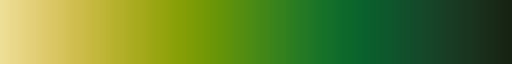

In [18]:
#we define here a function that will help us truncate our colorcharts to use them on clear color we use to representing fast Sea-ice. 
from matplotlib.colors import LinearSegmentedColormap
def truncate_cmap(cmap, start=0.0, stop=1.0, n=256):
    new_colors = cmap(np.linspace(start, stop, n))
    return LinearSegmentedColormap.from_list(f'trunc({cmap.name})', new_colors)

# On our visualisation tool, the quivers are monochromes (black). To reproduce that:
#cmap_quivers = ListedColormap(["#000000"])

#The speed colormap from cmocean is regularly used for speed information. However, it starts from a very light color that doesn't appear clearly on the 
# Let's truncate it:
cmap_origin = cmocean.cm.speed
cmap_quivers = truncate_cmap(cmap_origin, start=0.1, stop=1.0)

#Similarly, inferno is giving nice overview but the higher values this time are little visible. 
# Let's then truncate it:
# cmap_origin = mpl_cm.get_cmap('inferno')
# cmap_quivers = truncate_cmap(cmap_origin, start=0.0, stop=0.8)

cmap_quivers

Mapping figure based on retrieved netcdf file.

ice_drift_nh_polstere-625_multi-oi_202511041200-202511061200.nc
(1, 177, 119) (1, 177, 119)


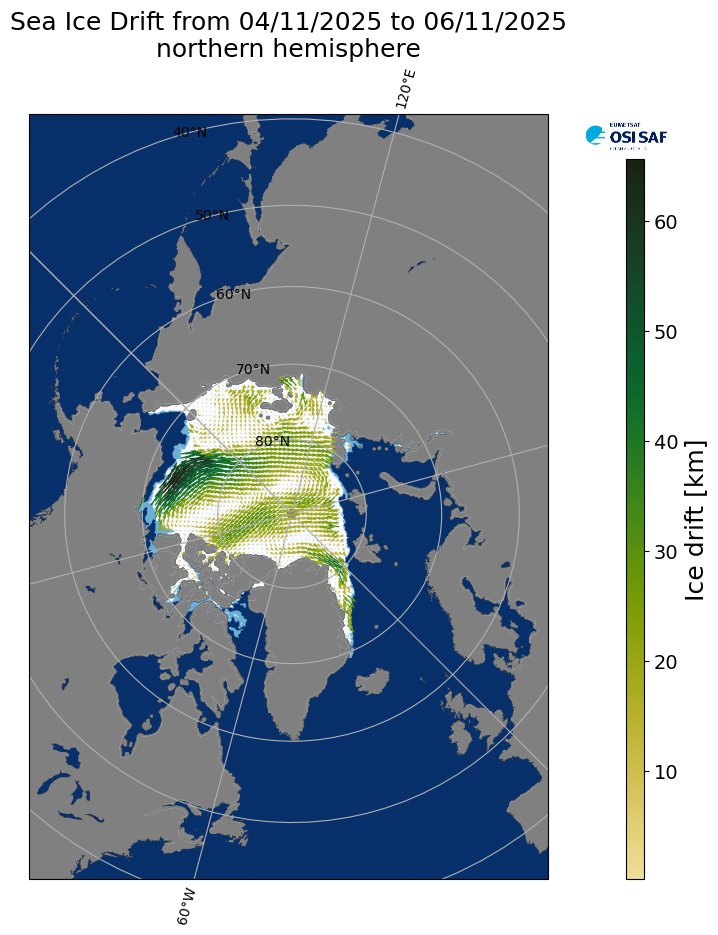

In [24]:
fig = plt.figure(figsize=(9,9))
# request output projection
output_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)

# map ice drift
im = mapping_ice_drift(directory, 
                       os.path.join(os.getcwd(), "products", "SI_drift", "nh", "SI_Edge", "ice_edge_nh_polstere-100_multi_"+ filedatum +"1200.nc"),
                       output_projection, 
                       cmap_quivers, 
                       title="Sea Ice Drift from "+filedate1+" to "+filedate2 + "\n""northern hemisphere")

# Adding a colorbar       
add_colorbar(im, fig, orientation="vertical", cmap=cmap_quivers)

We've been ploting the whole file, but the quivers appear really small in it, and there are large portion of the map that are not informative. Let's zoom in, starting by setting geographical area.

In [26]:
lon_min = -180
lon_max = 180
lat_min = 70
lat_max = 90

ice_drift_nh_polstere-625_multi-oi_202511041200-202511061200.nc
(1, 177, 119) (1, 177, 119)


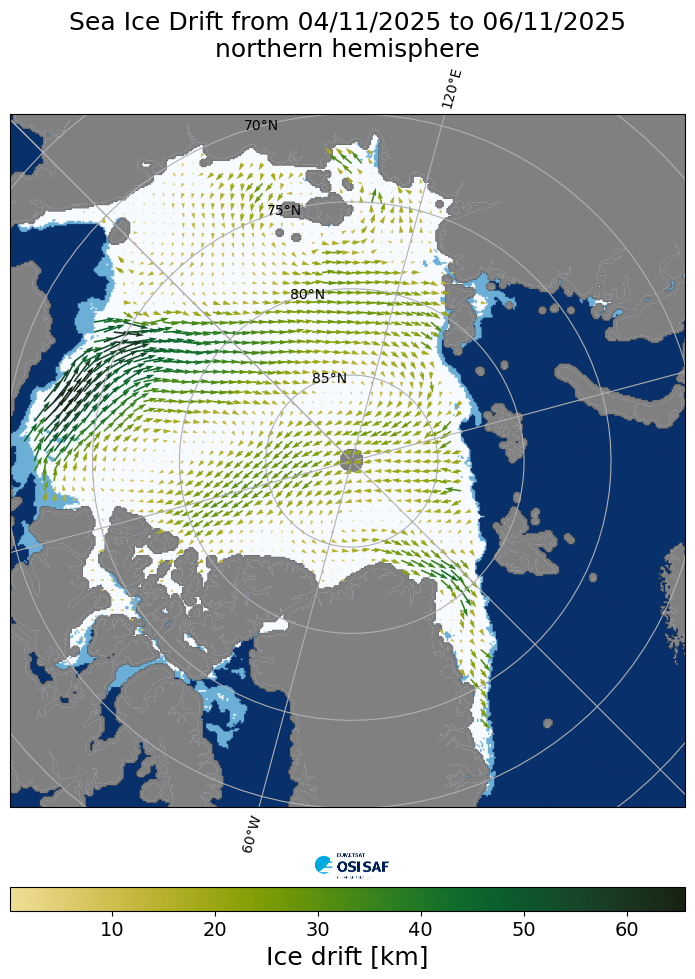

In [27]:
fig = plt.figure(figsize=(9,12))
# request output projection
output_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)

# map ice drift
im = mapping_ice_drift(directory, 
                       os.path.join(os.getcwd(), "products", "SI_drift", "nh", "SI_Edge", "ice_edge_nh_polstere-100_multi_"+ filedatum +"1200.nc"),
                       output_projection, 
                       cmap=cmap_quivers, 
                       title="Sea Ice Drift from "+filedate1+" to "+filedate2 + "\n""northern hemisphere",
                       region=[lon_min,lon_max,lat_min, lat_max])

# Adding a colorbar       
add_colorbar(im, fig, orientation="horizontal", cmap=cmap_quivers)

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3c_OSI_SAF_sea_ice_mapping_Ice_Type.ipynb" target="_blank"><< Mapping OSI SAF sea ice type</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3e_OSI_SAF_sea_ice_mapping_Ice_Emissivity.ipynb" target="_blank">Mapping OSI SAF sea ice emissivity >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>